# 画像分類のチュートリアル

実行環境(最新版をインストールしておけば大丈夫だと思います)
- Python : 3.10.12 (pyenv)
- torch : 2.0.1+cu118
- torchvision : 0.15.2+cu118
- timm : 1.0.7
- matplotlib : 3.7.2

# 📦モジュールのインポート

モデルの学習や画像の読み込みなどに使用するモジュールをインポートします。

In [3]:
import os, random
import numpy as np
import timm
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader

# 🎲 乱数シードを固定する

機械学習では、データのシャッフルや重みの初期化などに乱数が使われるため、  
毎回の実行で結果が少しずつ変わることがあります。

そこで、乱数の種（シード）を固定することで、実行ごとに同じ結果が得られるようにします。  
これを「再現性の確保」と呼びます。

以下のセルでは、Python・NumPy・PyTorch それぞれの乱数生成に対して同じシード値（今回は 42）を設定しています。

In [4]:
# seedの固定
def seed_everything(seed : int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything(42)

# 🖼️ 画像の準備  

今回は、100種類のスポーツ画像を分類するデータセットを使用します。  
以下のURLからデータセットをダウンロードしてください。

🔗 https://www.kaggle.com/datasets/gpiosenka/sports-classification

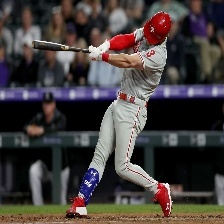 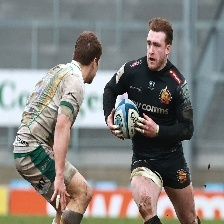 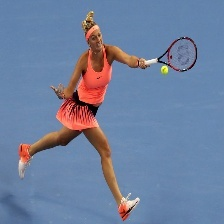 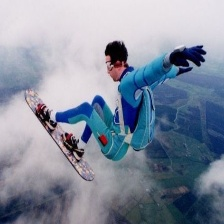


ダウンロードした zip ファイルを展開すると、train フォルダ、valid フォルダ、test フォルダが生成されます。  
それぞれのフォルダの中には、スポーツ名ごとのフォルダが配置されています。  

このノートブック（.ipynb ファイル）と同じ場所に data フォルダを作成し、  
その中に train、valid、test フォルダを配置してください。

以下のような構成になっていればOKです：

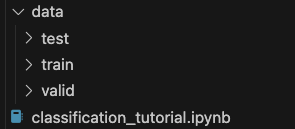

データセットは、あらかじめ以下の3種類に分かれています：

- 学習用データ（train）
    モデルを訓練するために使用します。

- 検証用データ（valid）
    モデルの性能を確認しながら、ハイパーパラメータ（学習率やエポック数など）を調整するために使用します。

- テスト用データ（test）
    最終的に学習済みモデルの精度を評価するために使用します。

このようにデータを分けることで、特定のデータ（検証用データ）に対してモデルが過剰に適応してしまう「[過学習](https://www.nri.com/jp/knowledge/glossary/lst/ka/overfitting)」を防ぐことができます。

# 🖼️ 画像データを表示してみる

1. 画像が配置されているディレクトリのパス（場所）を指定する

    train、valid、test フォルダの中には、以下のような 100種類のスポーツ名ごとのフォルダ があり、  
    それぞれのフォルダには、そのスポーツに関する画像が多数用意されています。

    （例：train/baseball/ や test/swimming/ など）

    スポーツのカテゴリ一覧 ：

    ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller derby', 'rollerblade racing', 'rowing', 'rugby', 'sailboat racing', 'shot put', 'shuffleboard', 'sidecar racing', 'ski jumping', 'sky surfing', 'skydiving', 'snow boarding', 'snowmobile racing', 'speed skating', 'steer wrestling', 'sumo wrestling', 'surfing', 'swimming', 'table tennis', 'tennis', 'track bicycle', 'trapeze', 'tug of war', 'ultimate', 'uneven bars', 'volleyball', 'water cycling', 'water polo', 'weightlifting', 'wheelchair basketball', 'wheelchair racing', 'wingsuit flying']

    ↓ 以下のように、スポーツ名がフォルダ名として付けられた構造になっています。  
    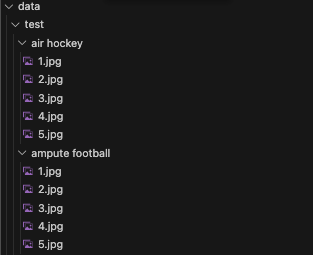

    今回は、train フォルダにある以下の3つのスポーツカテゴリについて、画像を実際に見てみます。

    - "air_hockey"

    - "basketball"

    - "baseball"

In [5]:
# trainフォルダ下のair hockey, basketball, baseballを選択
train_air_hockey_dir = "./data/train/air hockey"
train_basketball_dir = "./data/train/basketball"
train_baseball_dir = "./data/train/baseball"

2. スポーツの名前が付けられたフォルダの下に用意されているスポーツ画像のパスを取得する

    ここでは、glob モジュール を使って、特定のフォルダ内にある画像ファイルのパスを一括で取得します。

    📌 globモジュールの使い方： glob.glob(フォルダ名 + ' / * ')  
    　「*」 は「ワイルドカード」と呼ばれ、任意の文字列にマッチします。詳しくは検索して調べてみてください。

    さらに、取得したパスの数を len関数 を使って表示することで、画像の枚数を確認することができます。

    　📌 len関数の使い方： len(オブジェクト)  
    　たとえば、リストの要素数を知りたいときに使います。

In [6]:
# 各フォルダ下の画像のパスを取得
train_air_hockey_files = glob.glob(train_air_hockey_dir + "/*.jpg")
train_basketball_files = glob.glob(train_basketball_dir + "/*.jpg")
train_baseball_files = glob.glob(train_baseball_dir + "/*.jpg")

# 各フォルダ内の画像の枚数を確認
print("[train] : air hockey", len(train_air_hockey_files), "枚")
print("[train] : basketball", len(train_basketball_files), "枚")
print("[train] : baseball  ", len(train_baseball_files), "枚")
print()

# 実際にパスを出力してみる
print(train_air_hockey_files)

[train] : air hockey 112 枚
[train] : basketball 169 枚
[train] : baseball   174 枚

['./data/train/air hockey/001.jpg', './data/train/air hockey/002.jpg', './data/train/air hockey/003.jpg', './data/train/air hockey/004.jpg', './data/train/air hockey/005.jpg', './data/train/air hockey/006.jpg', './data/train/air hockey/007.jpg', './data/train/air hockey/008.jpg', './data/train/air hockey/009.jpg', './data/train/air hockey/010.jpg', './data/train/air hockey/011.jpg', './data/train/air hockey/012.jpg', './data/train/air hockey/013.jpg', './data/train/air hockey/014.jpg', './data/train/air hockey/015.jpg', './data/train/air hockey/016.jpg', './data/train/air hockey/017.jpg', './data/train/air hockey/018.jpg', './data/train/air hockey/019.jpg', './data/train/air hockey/020.jpg', './data/train/air hockey/021.jpg', './data/train/air hockey/022.jpg', './data/train/air hockey/023.jpg', './data/train/air hockey/024.jpg', './data/train/air hockey/025.jpg', './data/train/air hockey/026.jpg', './data

3. 画像を表示する

    2.で取得した画像のパスを使い、Pillowの Image クラスを用いて画像を読み込みます。  
    その後、matplotlib を使って画像を表示します。

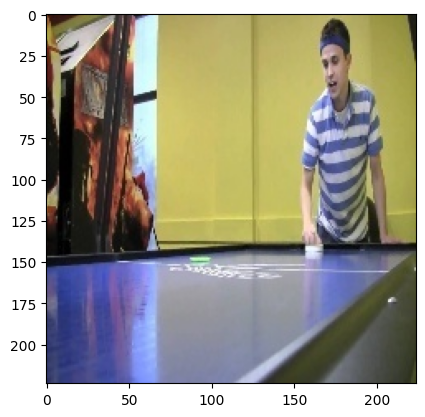

In [7]:
# 画像を読み込む
img = Image.open(train_air_hockey_files[0])
# 画像を表示
plt.imshow(img)
plt.show()

以下のように、subplot を用いることで複数の画像をまとめて表示することもできます。  
（ここはざっと見るだけで大丈夫です！）

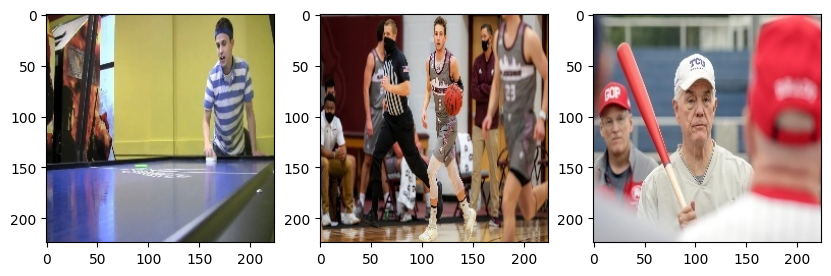

In [8]:
# 複数枚の画像をまとめて表示
plt.figure(figsize=(10, 3))
plt.subplot(1,3,1) # 1行3列の1番目の位置
plt.imshow(Image.open(train_air_hockey_files[0]))
plt.subplot(1,3,2) # 1行3列の2番目の位置
plt.imshow(Image.open(train_basketball_files[0]))
plt.subplot(1,3,3) # 1行3列の3番目の位置
plt.imshow(Image.open(train_baseball_files[0]))
plt.show()

4. 全てのスポーツ画像の枚数を把握する（※ここもざっと見るだけでOKです！）

    先ほどまでは、train フォルダ内にある3種類のスポーツ（air_hockey、basketball、baseball）について、  
    画像の枚数を確認し、実際に画像を表示しました。

    ここでは、すべてのスポーツカテゴリについて、フォルダごとの画像枚数を確認してみます。

    以下のグラフは、スポーツごとの画像枚数を示しています：

    縦軸：画像の枚数

    横軸：スポーツのカテゴリ名


    train フォルダ内では、スポーツによって画像の枚数にばらつきがあります。  
    一方で、valid フォルダと test フォルダでは、すべてのスポーツカテゴリにおいて5枚ずつ画像が用意されています。



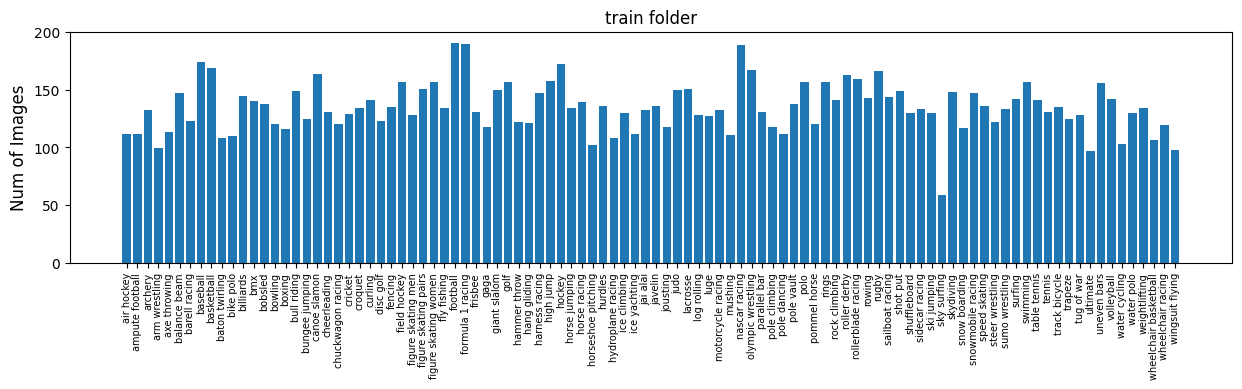

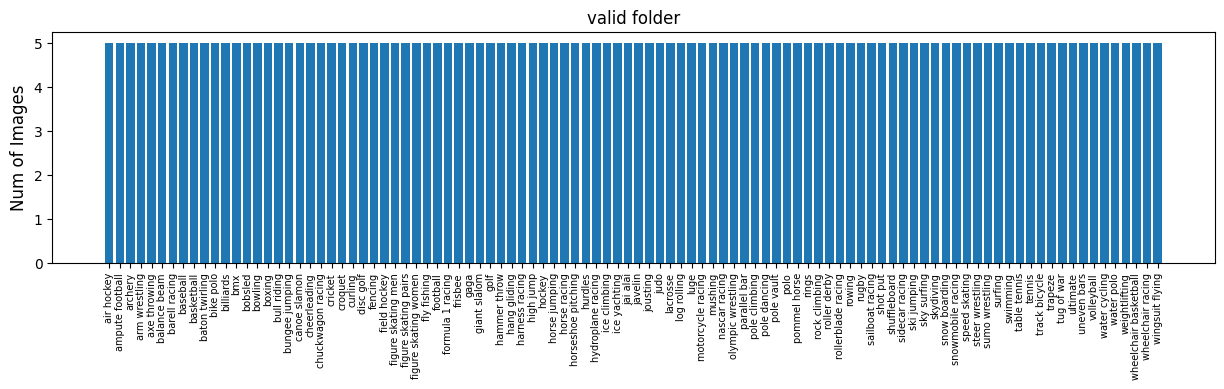

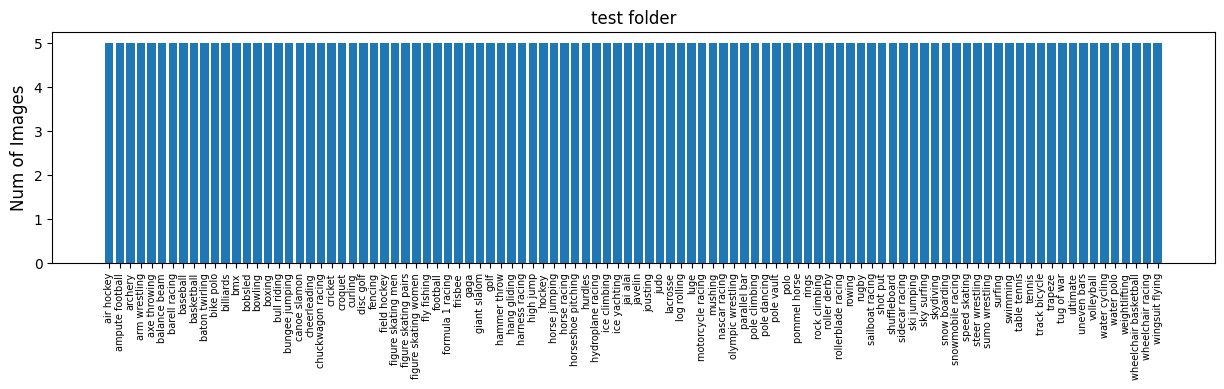

In [9]:
# 指定したフォルダ内のスポーツごとの枚数を表示する関数
def plot_bar_graph(dir_name):
    sport_dirs = glob.glob(dir_name + "/*")
    sport_names = []
    sport_counts = []
    for sport_dir in sport_dirs:
        sport_name = sport_dir.split("/")[-1]
        sport_names.append(sport_name)
        sport_files = glob.glob(sport_dir + "/*.jpg")
        sport_counts.append(len(sport_files))
    plt.figure(figsize=(15, 3))
    plt.bar(sport_names, sport_counts)
    plt.xticks(rotation=90, fontsize=7)
    plt.ylabel('Num of Images', fontsize=12)
    plt.title(dir_name.split("/")[-1] + " folder", fontsize=12)
    plt.show()

# 訓練データのスポーツごとの枚数を表示
plot_bar_graph("./data/train")

# 検証用データのスポーツごとの枚数を表示
plot_bar_graph("./data/valid")

# テスト用データのスポーツごとの枚数を表示
plot_bar_graph("./data/test")

# 📦 Dataset と DataLoader を作成する

モデルを学習させるときには、**データを小さなグループ（ミニバッチ）に分けて処理する「ミニバッチ学習」**がよく用いられます。  
このとき、ミニバッチのサイズは バッチサイズ（batch_size） と呼ばれます。

ミニバッチごとにデータを取り出す際に使用するのが、Dataset と DataLoader です。  
それぞれの役割は以下のとおりです：

## 🗂️ Dataset

Dataset は、データソース（画像とラベル）からデータを1件ずつ取り出し、必要な前処理（transform）を行うクラスです。

今回は、train・valid・test フォルダの下にスポーツ名ごとのフォルダが用意されているため、  
datasets.ImageFolder を使って Dataset を簡単に作成することができます。

たとえば、学習用の train_dataset は以下のように作成します：  

```Python
# train_datasetの作成例
train_dataset = datasets.ImageFolder("./data/train", transform=train_transform)
```
※ データの構成によっては、独自に Dataset クラスを定義する必要がある場合もあります。

## 🔁 DataLoader

DataLoader は、Dataset から取り出したデータを 指定したバッチサイズごとにまとめて順番に取り出すための仕組みです。

引数に shuffle を指定することで、データの取り出し順を制御することができます：

shuffle=True：データをランダムな順番で取り出します（→学習時に使用）

shuffle=False：常に同じ順番で取り出します（→検証・テスト時に使用）

たとえば、学習用の train_dataloader は以下のように作成します：

```Python
# train_loaderの作成例
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
```

## 🔧 前処理（transform）

前処理は、学習用と検証・テスト用で異なる設定を行うのが一般的です。

- 学習用  
    ランダムな回転や反転などのデータ拡張を加えることで、データの多様性を高め、モデルの汎化性能を向上させます。

- 検証用・テスト用  
    常に同じ形式で入力できるよう、リサイズや正規化などの基本的な前処理のみを行います。

以下のセルでは、transform（前処理）を定義し、dataset および dataloader を作成します。

In [10]:
# 学習用の前処理
train_transform = transforms.Compose([
    transforms.Resize((256,256)),            # 256x256にリサイズ
    transforms.CenterCrop((224,224)),        # 224x224にクロップ
    transforms.RandomHorizontalFlip(p=0.5),  # 50%の確率で左右反転
    transforms.ToTensor(),                   # Tensorに変換（[0, 1]の範囲に正規化）
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 平均と標準偏差で正規化
])

# 検証用とテスト用の前処理
val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasetの作成
train_dataset = datasets.ImageFolder("./data/train", transform=train_transform)
val_dataset = datasets.ImageFolder("./data/valid", transform=val_transform)
test_dataset = datasets.ImageFolder("./data/test", transform=val_transform)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🧠 モデルを作成する

今回は、timm（PyTorch Image Models） と呼ばれる、事前学習済みモデルを簡単に利用できるライブラリを使ってモデルを作成します。

timm では、timm.create_model という関数を使用してモデルを作成します。  
モデルを作成する際は、以下のように モデル名 や クラス数 を指定することで、目的に応じた分類モデルを構築できます：  

```Python
# モデルの作成例
model = timm.create_model("モデル名", pretrained=True, num_classes=クラス数)
```



また、モデルをGPUに載せることで、学習時や検証時の計算を高速化することができます。  
GPUを使用する場合は、以下のようにしてデバイスを指定します：  

```Python
# モデルをGPUに転送
model = model.to(device)
```

In [11]:
# クラス数の取得，確認
num_classes = len(train_dataset.classes)
print("クラス数: ", num_classes)

# モデルの作成
model_name = "resnet18"
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

# 使用するGPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

クラス数:  100


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

# ⚖️ 損失関数を定義する

損失関数（Loss Function） とは、正解ラベルとモデルの予測結果との間の誤差（ロス）を数値として計算するための関数です。  
この誤差をもとに、モデルは学習を通じてパラメータを調整していきます。

今回は、多クラスの画像分類を行うため、損失関数として CrossEntropyLoss を使用します。  
CrossEntropyLoss は、クラス数が複数ある分類問題において、一般的に使われる損失関数です。

In [12]:
# 損失関数
criterion = nn.CrossEntropyLoss()

# 🔧 最適化アルゴリズムを設定する

最適化アルゴリズム（Optimizer） とは、  
先ほど説明した 正解ラベル とモデルの 予測結果 の誤差（ロス）をできる限り小さくするためのアルゴリズムです。

学習では、学習率（Learning Rate） を調整しながら、  
モデルのパラメータを少しずつ更新して、最適な解に近づけていきます。

今回は、最適化アルゴリズムとして AdamW を使用します。  
AdamW は、画像分類をはじめ多くのタスクで使われている、安定性と性能のバランスが取れたアルゴリズムです。

In [13]:
# 学習率
lr = 0.0001
# optimizerの作成
optimizer = optim.AdamW(model.parameters(), lr=lr)

# 🔁 train_epoch 関数と val_epoch 関数を定義する

train_epoch 関数と val_epoch 関数では、モデルの学習と検証をそれぞれ1エポック分実行します。

- train_epoch 関数  

    この関数では、1エポック分の学習処理を行い、エポックごとの 損失（loss） と 正解率（accuracy） を計算します。  
    学習時には、モデルを「訓練モード」に切り替える必要があります。以下のように記述します：
    
    ```Python
    model.train()
    ```

- val_epoch 関数
　
    この関数では、1エポック分の検証処理を行い、同様に 損失（loss） と 正解率（accuracy） を計算します。  
    検証時には、モデルを「評価モード」に切り替える必要があります。以下のように記述します：

    ```Python
    model.eval()
    ```

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    # lossとaccの初期化
    train_loss, train_acc = 0, 0 # このtrain_lossとtrain_accにlossとaccを加算していき，最後にデータ数で割ることで平均を計算する

    model.train() # モデルを学習モードに設定
    for images, labels in tqdm(dataloader): # dataloaderからデータを取り出す
        images, labels = images.to(device), labels.to(device) # データをGPUに転送
        optimizer.zero_grad() # 勾配の初期化
        outputs = model(images) # モデルで推論
        loss = criterion(outputs, labels) # lossの計算
        train_loss += loss.item() * images.size(0) # lossを蓄積
        acc = (outputs.max(1)[1] == labels).sum() # accの計算
        train_acc += acc.item() # accを蓄積
        loss.backward() # 逆伝播
        optimizer.step() # パラメータの更新
    avg_train_loss = train_loss / len(dataloader.dataset) # lossの平均を計算
    avg_train_acc = train_acc / len(dataloader.dataset) # accの平均を計算
    return avg_train_loss, avg_train_acc

def val_epoch(model, dataloader, criterion, device):
    # lossとaccの初期化
    val_loss, val_acc = 0,0
    model.eval() # モデルを評価モードに設定
    with torch.no_grad(): # val_epoch関数では，勾配を計算しない
        for images, labels in tqdm(dataloader): # dataloaderからデータを取り出す
            images, labels = images.to(device), labels.to(device) # データをGPUに転送
            outputs = model(images) # モデルで推論
            loss = criterion(outputs, labels) # lossの計算
            val_loss += loss.item() * images.size(0) # lossを蓄積
            acc = (outputs.max(1)[1] == labels).sum() # accの計算
            val_acc += acc.item() # accを蓄積
    avg_val_loss = val_loss / len(dataloader.dataset) # lossの平均を計算
    avg_val_acc = val_acc / len(dataloader.dataset) # accの平均を計算
    return avg_val_loss, avg_val_acc

# 🏋️‍♂️ 学習を実行する

モデルを学習する際には、学習用データ全体を何回繰り返して学習させるかを示す  
エポック数（epoch） をあらかじめ設定しておく必要があります。

エポック数の最適な値は、モデルの構造や使用するデータの量、ハイパーパラメータの設定などによって異なります。

学習は、設定したエポック数に応じて for 文でループ処理を行い、    
各エポックの中でモデルの学習（train_epoch）と検証（val_epoch）を実行します。

各エポックごとに計算された train_loss、train_acc、val_loss、val_acc はリストに保存しておき、  
あとで学習曲線（損失や精度の推移）を可視化するために使用します。

学習がすべて完了したら、学習済みのモデルをファイルとして保存します。

In [15]:
# エポック数
num_epochs = 30

In [16]:
# train_loss, train_acc, val_loss, val_accを保存するリスト
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

# 学習
for epoch in range(num_epochs):
    # train_epoch関数とval_epoch関数で1エポック分の学習と評価を行う
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = val_epoch(model, test_loader, criterion, device)
    
    # 各値をリストに追加
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    # ログを出力
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

# modelの保存
torch.save(model.state_dict(), f"{model_name}_epoch{num_epochs}.pth")

  0%|          | 0/106 [00:00<?, ?it/s]/home/khenmi/.pyenv/versions/3.10.12/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


Epoch: 1, train_loss: 4.4462, train_acc: 0.0749, val_loss: 4.1822, val_acc: 0.1920


100%|██████████| 16/16 [00:00<00:00, 17.63it/s]


Epoch: 2, train_loss: 3.8364, train_acc: 0.3003, val_loss: 3.2961, val_acc: 0.3860


100%|██████████| 16/16 [00:00<00:00, 16.73it/s]


Epoch: 3, train_loss: 2.9845, train_acc: 0.4873, val_loss: 2.4264, val_acc: 0.5900


100%|██████████| 16/16 [00:00<00:00, 16.56it/s]


Epoch: 4, train_loss: 2.2550, train_acc: 0.6344, val_loss: 1.7701, val_acc: 0.7420


100%|██████████| 16/16 [00:00<00:00, 18.48it/s]


Epoch: 5, train_loss: 1.7147, train_acc: 0.7173, val_loss: 1.3050, val_acc: 0.8200


100%|██████████| 16/16 [00:00<00:00, 17.15it/s]


Epoch: 6, train_loss: 1.3280, train_acc: 0.7753, val_loss: 0.9915, val_acc: 0.8660


100%|██████████| 16/16 [00:00<00:00, 16.29it/s]


Epoch: 7, train_loss: 1.0594, train_acc: 0.8140, val_loss: 0.7832, val_acc: 0.8960


100%|██████████| 16/16 [00:00<00:00, 18.05it/s]


Epoch: 8, train_loss: 0.8672, train_acc: 0.8424, val_loss: 0.6383, val_acc: 0.8960


100%|██████████| 16/16 [00:00<00:00, 17.10it/s]


Epoch: 9, train_loss: 0.7184, train_acc: 0.8675, val_loss: 0.5360, val_acc: 0.9160


100%|██████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 10, train_loss: 0.6074, train_acc: 0.8876, val_loss: 0.4596, val_acc: 0.9220


100%|██████████| 16/16 [00:00<00:00, 17.90it/s]


Epoch: 11, train_loss: 0.5124, train_acc: 0.9079, val_loss: 0.4028, val_acc: 0.9280


100%|██████████| 16/16 [00:00<00:00, 17.63it/s]


Epoch: 12, train_loss: 0.4441, train_acc: 0.9191, val_loss: 0.3584, val_acc: 0.9320


100%|██████████| 16/16 [00:00<00:00, 16.83it/s]


Epoch: 13, train_loss: 0.3807, train_acc: 0.9326, val_loss: 0.3204, val_acc: 0.9420


100%|██████████| 16/16 [00:00<00:00, 17.02it/s]


Epoch: 14, train_loss: 0.3279, train_acc: 0.9433, val_loss: 0.2880, val_acc: 0.9440


100%|██████████| 16/16 [00:00<00:00, 16.33it/s]


Epoch: 15, train_loss: 0.2857, train_acc: 0.9522, val_loss: 0.2763, val_acc: 0.9380


100%|██████████| 16/16 [00:00<00:00, 17.09it/s]


Epoch: 16, train_loss: 0.2482, train_acc: 0.9604, val_loss: 0.2507, val_acc: 0.9440


100%|██████████| 16/16 [00:00<00:00, 18.73it/s]


Epoch: 17, train_loss: 0.2169, train_acc: 0.9684, val_loss: 0.2356, val_acc: 0.9500


100%|██████████| 16/16 [00:00<00:00, 17.25it/s]


Epoch: 18, train_loss: 0.1861, train_acc: 0.9744, val_loss: 0.2192, val_acc: 0.9540


100%|██████████| 16/16 [00:00<00:00, 16.52it/s]


Epoch: 19, train_loss: 0.1600, train_acc: 0.9807, val_loss: 0.2124, val_acc: 0.9560


100%|██████████| 16/16 [00:00<00:00, 17.12it/s]


Epoch: 20, train_loss: 0.1394, train_acc: 0.9838, val_loss: 0.2028, val_acc: 0.9500


100%|██████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 21, train_loss: 0.1232, train_acc: 0.9873, val_loss: 0.1940, val_acc: 0.9520


100%|██████████| 16/16 [00:00<00:00, 16.79it/s]


Epoch: 22, train_loss: 0.1065, train_acc: 0.9898, val_loss: 0.1818, val_acc: 0.9480


100%|██████████| 16/16 [00:00<00:00, 17.59it/s]


Epoch: 23, train_loss: 0.0917, train_acc: 0.9930, val_loss: 0.1776, val_acc: 0.9540


100%|██████████| 16/16 [00:01<00:00, 15.85it/s]


Epoch: 24, train_loss: 0.0814, train_acc: 0.9935, val_loss: 0.1705, val_acc: 0.9520


100%|██████████| 16/16 [00:00<00:00, 17.19it/s]


Epoch: 25, train_loss: 0.0698, train_acc: 0.9959, val_loss: 0.1661, val_acc: 0.9580


100%|██████████| 16/16 [00:00<00:00, 17.25it/s]


Epoch: 26, train_loss: 0.0593, train_acc: 0.9967, val_loss: 0.1588, val_acc: 0.9580


100%|██████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 27, train_loss: 0.0550, train_acc: 0.9976, val_loss: 0.1599, val_acc: 0.9560


100%|██████████| 16/16 [00:00<00:00, 16.58it/s]


Epoch: 28, train_loss: 0.0471, train_acc: 0.9982, val_loss: 0.1558, val_acc: 0.9540


100%|██████████| 16/16 [00:00<00:00, 16.90it/s]


Epoch: 29, train_loss: 0.0429, train_acc: 0.9980, val_loss: 0.1530, val_acc: 0.9580


100%|██████████| 16/16 [00:00<00:00, 16.55it/s]


Epoch: 30, train_loss: 0.0367, train_acc: 0.9988, val_loss: 0.1511, val_acc: 0.9580


# 📈 Accuracy（正解率）と Loss（損失）を表示する

学習中に記録した Accuracy（正解率） と Loss（損失） の値を可視化します。  
これにより、モデルがエポックごとにどのように学習・改善されていったのかを視覚的に確認することができます。



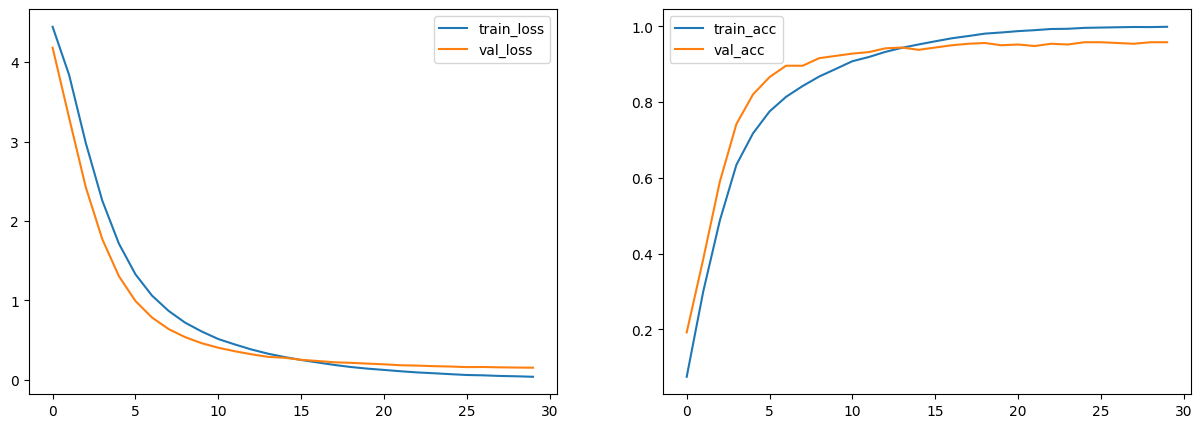

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label="train_loss") # train_loss_listをプロットし，ラベルを指定
plt.plot(val_loss_list, label="val_loss") # val_loss_listをプロットし，ラベルを指定
plt.legend() # 凡例を表示
plt.subplot(1,2,2)
plt.plot(train_acc_list, label="train_acc")
plt.plot(val_acc_list, label="val_acc")
plt.legend()
plt.show()

# 🧪 テスト用データに対する精度の確認

学習用データと検証用データを使って学習したモデルを保存したファイルから再度ロードし、  
テスト用データに対する最終的な精度を検証します。

モデルをロードする際には、以下の手順で行います：

1. モデルの構造をもう一度定義する

2. 保存されたパラメータ（重み）を読み込む

In [18]:
# モデルの定義
model_name = "resnet18"
model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)

# モデルの重みを読み込む
model.load_state_dict(torch.load(f"{model_name}_epoch{num_epochs}.pth"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

テスト用データを用いて、学習済みモデルの最終的な精度（Accuracy）を評価します。  
ここでは、以下で定義する predict 関数を使用して、モデルがどれだけ正しく分類できているかを確認します。

モデルは検証モード（model.eval()）に切り替え、torch.no_grad() を使って不要な勾配計算を省略することで、効率的に評価を行います。  
評価結果はパーセンテージで出力されます。

In [19]:
def predict(model, dataloader, device):
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            acc = (outputs.max(1)[1] == labels).sum() # accの計算
            test_acc += acc.item()
    avg_test_acc = test_acc / len(dataloader.dataset)
    return avg_test_acc

In [20]:
test_acc = predict(model, test_loader, device)
print("テスト用データに対する精度(Acc): ", test_acc*100, "%")

100%|██████████| 16/16 [00:00<00:00, 17.30it/s]

テスト用データに対する精度(Acc):  95.8 %
